In [13]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import pandas as pd
import tiktoken
# import openai
import numpy as np
# from openai.embeddings_utils import distances_from_embeddings, cosine_similarity
from ast import literal_eval

In [26]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]{0,1}://.+$'

# Define root domain to crawl
domain = "www.salientpr.com"
full_url = "https://www.salientpr.com/"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

################################################################################
### Step 2
################################################################################

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

################################################################################
### Step 3
################################################################################

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif (
                link.startswith("#")
                or link.startswith("mailto:")
                or link.startswith("tel:")
            ):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


################################################################################
### Step 4
################################################################################

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

In [4]:
crawl(full_url)

https://www.salientpr.com/
https://www.salientpr.com/enterprise-pr-wins
https://www.salientpr.com/blog/blog-post-title-four-bf9pg
https://www.salientpr.com/blog?author=56aaf45f2399a3fc54d63872
https://www.salientpr.com/blog/top-public-relations-firms
https://www.salientpr.com/blog/a-guide-to-creating-a-perfect-media-kit
https://www.salientpr.com/blog/a-2023-guide-to-pr-success
https://www.salientpr.com/martech-pr-wins
https://www.salientpr.com/how
https://www.salientpr.com/ai-pr-wins
https://www.salientpr.com/venture-capital-pr-wins
https://www.salientpr.com/developer-pr-wins
https://www.salientpr.com/new-folder
HTTP Error 429: Too Many Requests
https://www.salientpr.com/blog
https://www.salientpr.com/agtech-pr-wins
https://www.salientpr.com/crypto-pr-wins
https://www.salientpr.com
https://www.salientpr.com/mobile-pr-wins
HTTP Error 404: Not Found
https://www.salientpr.com/iot-pr-wins
https://www.salientpr.com/about
https://www.salientpr.com/saas-pr-wins
https://www.salientpr.com/conta

In [96]:
## process files
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[0:-4].replace('_', '/').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()


,fname,text
0,www.salientpr.com/mobile-pr-wins,www.salientpr.com/mobile-pr-wins. Salient PR...
1,www.salientpr.com/blog/a-2023-guide-to-pr-success,www.salientpr.com/blog/a-2023-guide-to-pr-succ...
2,www.salientpr.com/why,www.salientpr.com/why. 429 Too Many Requests ...
3,www.salientpr.com/,www.salientpr.com/. Salient PR 0...
4,www.salientpr.com/martech-pr-wins,www.salientpr.com/martech-pr-wins. MarTech P...


<Axes: >

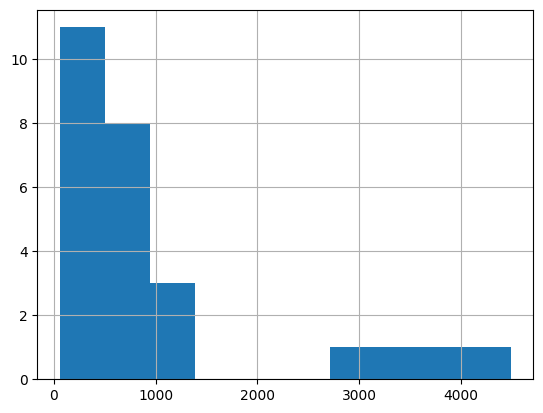

In [97]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [98]:
df['embeddings'] = df.text.apply(lambda x: np.array(list(model.encode(x))))
df.to_csv('processed/embeddings.csv')
df.head()

,title,text,n_tokens,embeddings
0,www.salientpr.com/mobile-pr-wins,www.salientpr.com/mobile-pr-wins. Salient PR...,311,"[-0.061270252, 0.017113695, -0.028366456, -0.0..."
1,www.salientpr.com/blog/a-2023-guide-to-pr-success,www.salientpr.com/blog/a-2023-guide-to-pr-succ...,3359,"[-0.03524419, -0.0501065, -0.038870264, -0.008..."
2,www.salientpr.com/why,www.salientpr.com/why. 429 Too Many Requests ...,63,"[-0.025948357, -0.047046743, 0.04606438, 0.030..."
3,www.salientpr.com/,www.salientpr.com/. Salient PR 0...,639,"[-0.054520756, -0.008512968, -0.0119128125, -0..."
4,www.salientpr.com/martech-pr-wins,www.salientpr.com/martech-pr-wins. MarTech P...,609,"[-0.059559673, -0.07937419, -0.073274545, -0.0..."


In [99]:
# df=pd.read_csv('processed/embeddings.csv', index_col=0)
# df['embeddings'] = df['embeddings'].apply(np.array)

# df.head()

In [51]:
type(df['embeddings'].values[0])

numpy.ndarray

In [102]:
question = 'What does salient pr do?'

q_embeddings = model.encode(question)

df['sim'] = util.cos_sim(q_embeddings, df['embeddings']).tolist()[0]

df.sort_values('sim', ascending=False)

,title,text,n_tokens,embeddings,sim
3,www.salientpr.com/,www.salientpr.com/. Salient PR 0...,639,"[-0.054520756, -0.008512968, -0.0119128125, -0...",0.618009
19,www.salientpr.com/blog/top-public-relations-firms,www.salientpr.com/blog/top-public-relations-fi...,3992,"[-0.037255082, -0.09170573, -0.05176249, -0.00...",0.515617
6,www.salientpr.com/blog/blog-post-title-four-bf9pg,www.salientpr.com/blog/blog-post-title-four-bf...,4489,"[-0.030947406, -0.06571724, -0.055176053, -0.0...",0.513167
24,www.salientpr.com/blog?author=56aaf45f2399a3fc...,www.salientpr.com/blog?author=56aaf45f2399a3fc...,459,"[-0.015988514, -0.07720599, -0.016917568, -0.0...",0.480505
16,www.salientpr.com/blog,www.salientpr.com/blog. Blog 2 — Salient PR ...,442,"[-0.059261255, -0.08325477, -0.025425283, -0.0...",0.466906
1,www.salientpr.com/blog/a-2023-guide-to-pr-success,www.salientpr.com/blog/a-2023-guide-to-pr-succ...,3359,"[-0.03524419, -0.0501065, -0.038870264, -0.008...",0.454855
11,www.salientpr.com/join-us,www.salientpr.com/join-us. Join Us! — Salien...,1013,"[-0.0748088, -0.050436717, -0.038407262, 0.030...",0.448688
4,www.salientpr.com/martech-pr-wins,www.salientpr.com/martech-pr-wins. MarTech P...,609,"[-0.059559673, -0.07937419, -0.073274545, -0.0...",0.446941
7,www.salientpr.com/contact-us,www.salientpr.com/contact-us. Contact 1 — Sa...,423,"[-0.08943122, -0.04045021, -0.0086311465, 0.03...",0.437096
13,www.salientpr.com/ai-pr-wins,www.salientpr.com/ai-pr-wins. AI PR — Salien...,814,"[-0.045559168, -0.069607414, -0.07135637, -0.0...",0.417626


In [68]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = model.encode(question)

    # Get the distances from the embeddings
    df['distances'] = util.cos_sim(q_embeddings, df['embeddings']).tolist()


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)